### Packages

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

TARGET = "HeartDisease"
DATASET = Path("../Dataset/heartdisease_indicator_train.csv")
VALIDATION_DATASET = Path("../Dataset/heartdisease_indicator_test.csv")

In [38]:
TRAIN_TEST = pd.read_csv(DATASET)
VALID = pd.read_csv(VALIDATION_DATASET)

### Preprocessing

In [39]:
TRAIN_TEST.describe(include='O').T.unique

HeartDisease         2
Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        2
SkinCancer           2
Name: unique, dtype: object

In [40]:
REPLACE_VALUES = {
                  'Smoking': {'No':0,'Yes':1}, 
                  'AlcoholDrinking': {'No':0,'Yes':1}, 
                  'Stroke': {'No':0,'Yes':1},
                  'DiffWalking': {'No':0,'Yes':1},
                  'Diabetic': {'No':0,'No, borderline diabetes':0,
                               'Yes (during pregnancy)':1,'Yes':1},
                  'PhysicalActivity': {'No':0,'Yes':1},
                  'Asthma': {'No':0,'Yes':1},
                  'KidneyDisease': {'No':0,'Yes':1},
                  'SkinCancer': {'No':0,'Yes':1},
                  'Sex': {'Male':0,'Female':1},
                  'AgeCategory': {'18-24':0,'25-29':1,'30-34':2,'35-39':3,
                                  '40-44':4,'45-49':5,'50-54':6,'55-59':7,
                                  '60-64':8,'65-69':9,'70-74':10,
                                  '75-79':11,'80 or older':12},
                  'GenHealth': {'Excellent':0,'Very good':1,
                                'Good':2,'Fair':3,'Poor':4},
                  'HeartDisease': {'No':0,'Yes':1}
    }

In [41]:
from sklearn.base import TransformerMixin



class PreProcess(TransformerMixin):

    def __init__(self, target = 'HeartDisease'):
        self.target = target
    
    def fit(self, X, y = None):
        return self
        
    def transform(self, X, y = None):
        
        for key, value in REPLACE_VALUES.items():
            if key != self.target:
                X[key].replace(value, inplace = True)
        
        if y is not None:
            y.replace(REPLACE_VALUES[self.target], inplace = True)
            return X, y
        return X

In [42]:
TRAIN_TEST['GenHealth'] = pd.Categorical(TRAIN_TEST.GenHealth, 
                      categories=["Poor","Fair","Good","Very good","Excellent"],
                      ordered=True)

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(TRAIN_TEST.drop(TARGET, axis = 1), TRAIN_TEST[TARGET])

In [44]:
preprocess = PreProcess()

In [45]:
(X_train, Y_trian), (X_test, Y_test) = preprocess.transform(X_train, Y_train), preprocess.transform(X_test, Y_test)

### Baseline Model

In [67]:
model = RandomForestClassifier(n_estimators=50, max_depth=10, 
                               random_state=42)

In [68]:
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)

In [69]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

<AxesSubplot:ylabel='cols'>

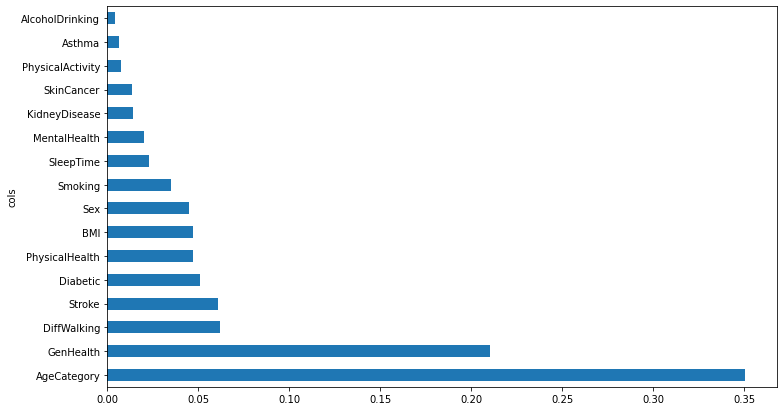

In [70]:
fi = rf_feat_importance(model, X_train)

plot_fi(fi)

In [79]:
import matplotlib.pyplot as plt

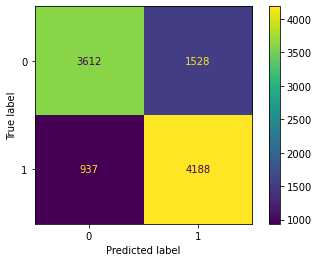

In [82]:
y_pred = model.predict(X_test)
ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test)

In [72]:
valid_x, valid_y = preprocess.transform(VALID.drop(TARGET, axis = 1), VALID[TARGET])

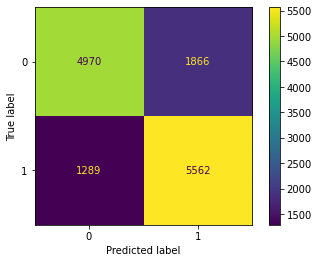

In [73]:
ConfusionMatrixDisplay.from_estimator(model, valid_x, valid_y)

In [74]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.70      0.75      5140
           1       0.73      0.82      0.77      5125

    accuracy                           0.76     10265
   macro avg       0.76      0.76      0.76     10265
weighted avg       0.76      0.76      0.76     10265



### Save Model

In [63]:
import joblib

In [64]:
joblib.dump(model, '../Models/model/classifier.pkl')

['../Models/model/classifier.pkl']

In [66]:
model = joblib.load('../Models/model/classifier.pkl')
model.predict_proba(X_train.sample(random_state = 54)).flatten()

array([0.66632438, 0.33367562])